# Using Python to demonstrate simple orbital mechanics
This notebook illustrates two different Python functions to integrate the equation governing the motion of a body in the gravitationl field of another:
$$a = \mu / P^2$$
Here the standard gravitational parameter $\mu$ of body 1 (e.g. planet Earth) relates the acceleration $a$ of body 2 (e.g. a satellite) within its gravitational field to the distance between body 2 and the center of body 1 $P$. Note that this only represents the acceleration of body 2 due to the gravity of body 1. Other accelerations are not included. 

In [18]:
# Load relevant modules
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Part 1: Calculating the orbits

## 1.1 Set intial conditions

In [31]:
# Define the state vector by specifying P0 and V0
# Some different P0 - initial positions
P01=[ 6100, 4500, 0]
P02=[-2.3351e4, -2.1746e4, -2.1316e3]

# Some different V0 - initial velocities
V01=[ 2.9268, -0.1393, -0.0792]
V02=[ 2.9268, -1.1393, -0.0792]
V03=[ 0,  8, 3.8]
V04=[-2.7874, 2.6403, 0]

# Some state vectors. Try different combinations of P0 and V0
X01 = np.array([P01, V01])
X02 = np.array([P02, V02])

## 1.2 Do the integration
In order to update the orbit from the initial values, we need to solve an initial value problem. There are various Python functions that can be used for this. Here, we compare Scipy's ```odeint``` (_~"ordinary differential equation integration"_) and ```solve_ivp``` (_~"solve initial value problem"_) functions. If you were doing this in Matlab, you could use the ```ode45``` function. 

The arrays solivp1 and solode1 give the positions (P) and velocities (V) for orbit 1 for the given time span, and solivp2 and solode2 give the P and V for orbit 2 for its time span. Note that the order of the arguments is switched between the functions! (solivp: specify [i, :], solode: specify [:, i], i = 0,1,2)

Some sources for the integration: 
https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python
https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/

In [32]:
def update_orbit(t, X):
    """
        Function to update the orbit. 
        MU is the standard gravitational parameter:
            MU = G * M, where 
            M = M_Earth = 5.97×10^{24} kg
            G = 6.67×10^{−11} m3⋅kg−1⋅s−2
        
        The change in velocity dV = -mu * P / norm(P)^3.
        
        Using flatten() on the final state vector seems 
        to be necessary for the scipy functions to work.
    """
    MU = 398600    #units: km^3 s^{-2}
    P = X[0:3]     #P-part of the state vector X
    V = X[3:]      #V-part of the state vector X
    
    dP = V
    dV = -MU / (np.linalg.norm(P,2)**3) * P
    return np.array([dP,dV]).flatten()

# Now, use solve_ivp and odeint to update the orbits
# for given time intervals and starting conditions. 
# Note that solve_ivp somehow defines its own time-step.
#
# For the second orbit (different initial conditions),
# make the time longer to get a full orbit.

# SOLVE_IVP
t_start = 0.
t_final = 3600.

solivp1 = solve_ivp(update_orbit, [t_start, t_final], X01.flatten())
solivp2 = solve_ivp(update_orbit, [t_start, t_final*10.], X02.flatten())

# ODEINT
t_step = 50.
tspan = np.arange(t_start, t_final, t_step)

solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True)
solode2 = odeint(update_orbit, X02.flatten(), tspan*10, tfirst=True)

# Part 2: Visualising the orbits
## 2.1 Static visualisation
The next two cells show some static visualisations the orbits. We're plotting the solutions for the three components of P for both of the orbits to compare between them. You can also separate them or plot the V components. 

Notice the different results between the two integration methods! 

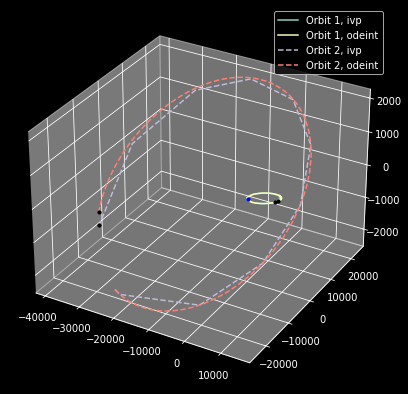

In [33]:
%matplotlib inline
# Set a dark background... since... space is dark.
plt.style.use('dark_background')

FIG = plt.figure(figsize=(7,7))
AX = FIG.add_subplot(1,1,1, projection='3d')

# Create a blue dot that represents the Earth, add it to the ax 
# (not strictly necessary but nice to illustrate the origin)
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1
AX.plot(solivp1.y[0, :], solivp1.y[1, :], solivp1.y[2, :], label='Orbit 1, ivp')
AX.scatter(solivp1.y[0, -1], solivp1.y[1,-1], solivp1.y[2,-1],c='k',s=10)

AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 2
AX.plot(solivp2.y[0, :], solivp2.y[1, :], solivp2.y[2, :], linestyle='--', label='Orbit 2, ivp')#T1, Y1[0,:])
AX.scatter(solivp2.y[0, -1], solivp2.y[1,-1], solivp2.y[2,-1],c='k',s=10)

AX.plot(solode2[:, 0], solode2[:, 1], solode2[:, 2], linestyle='--', label='Orbit 2, odeint')
AX.scatter(solode2[-1,0], solode2[-1,1], solode2[-1,2],c='k',s=10)

# Configuring the plot
#AX.set_aspect("equal")
AX.legend()

plt.show()

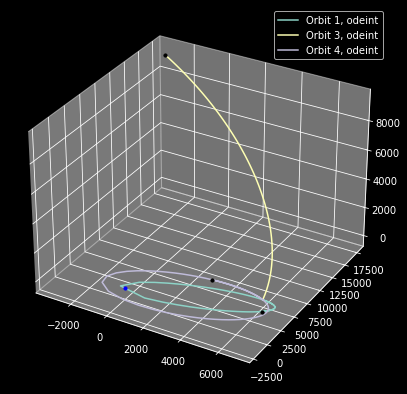

In [34]:
# Make two orbits with the same P0 but different V0 using ODEINT.
# You can see from the plot that they travel different distances
# in the same time. 
X03 = np.array([P01, V03])
X04 = np.array([P01, V04])

solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True)
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True)

# Plotting
FIG2 = plt.figure(figsize=(7,7))
AX = FIG2.add_subplot(1,1,1, projection='3d')
AX.scatter([0], [0], [0], color="b", s=10)

# Orbit 1 (re-used from above)
AX.plot(solode1[:, 0], solode1[:, 1], solode1[:, 2], label='Orbit 1, odeint')
AX.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

# Orbit 3
AX.plot(solode3[:, 0], solode3[:, 1], solode3[:, 2], label='Orbit 3, odeint')
AX.scatter(solode3[-1,0], solode3[-1,1], solode3[-1,2],c='k',s=10)

# Orbit 4
AX.plot(solode4[:, 0], solode4[:, 1], solode4[:, 2], label='Orbit 4, odeint')
AX.scatter(solode4[-1,0], solode4[-1,1], solode4[-1,2],c='k',s=10)

AX.legend()
plt.show()

## 2.2 Animated visualisation
It is also possible to produce an animation of the orbit by updating the plot at each time step. This is done by adding a function which updates the plot at each time step. The next step would be to make the same animation but with an added perturbation in the orbit to illustrate e.g. an egine firing.

<IPython.core.display.Javascript object>


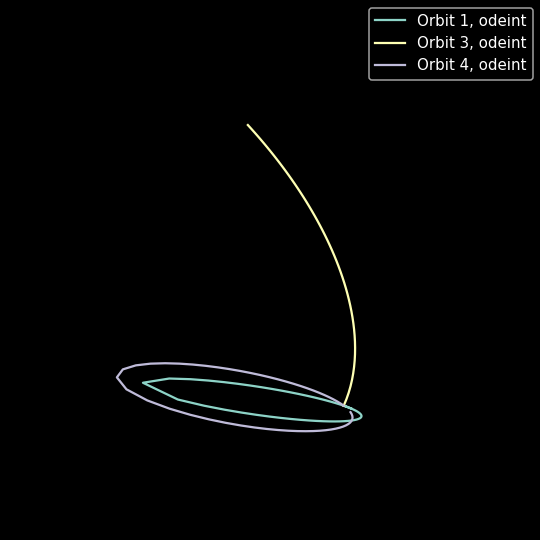

/tmp/ipykernel_744/154059326.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  AX = Axes3D(FIG3)


In [35]:
# This is all nice but let's animate this same plot
# change the matplotlib engine
%matplotlib notebook
# For some reason it needs to be transposed for the animation to work
solode1 = odeint(update_orbit, X01.flatten(), tspan, tfirst=True).transpose()
solode3 = odeint(update_orbit, X03.flatten(), tspan, tfirst=True).transpose()
solode4 = odeint(update_orbit, X04.flatten(), tspan, tfirst=True).transpose()

# Initialise the figure
FIG3 = plt.figure(figsize=(5,5))
AX = Axes3D(FIG3)

# Initialise the plots (they cannot be empty in 3D)
orbitPlots = [AX.plot(solode1[0, 0:1], solode1[1, 0:1], solode1[2, 0:1], label='Orbit 1, odeint')[0], AX.plot(solode3[0, 0:1], solode3[1, 0:1], solode3[2, 0:1], label='Orbit 3, odeint')[0], AX.plot(solode4[0, 0:1], solode4[1, 0:1], solode4[2, 0:1], label='Orbit 4, odeint')[0]]
orbitData = [solode1,solode3,solode4]

# Make a function that will be called to update every frame
def animate(i, data, plots):
    if i==0:
        return plots
    else:
        for plot, dat in zip(plots, data):
            plot.set_data(dat[0:2,:i])
            plot.set_3d_properties(dat[2,:i])
        return plots

# Setting the axes properties
AX.axis("off")
AX.set_xlim3d([-3000, 8000])
AX.set_ylim3d([-3000, 20000])
AX.set_zlim3d([-1000, 10000])
AX.set_title('3D Trajectories')
AX.legend()

#Call the magic function that makes the animation
animation = FuncAnimation(FIG3, animate, fargs=(orbitData, orbitPlots), 
                          frames=range(len(solode3[0,:])), interval=10, 
                          repeat=True, blit=False)
plt.show()

<IPython.core.display.Javascript object>


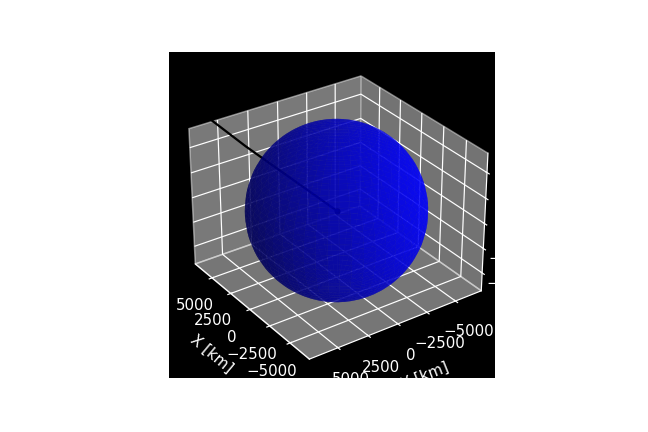

In [36]:
# Setting up Spherical Earth to Plot
N = 50
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi, N)
theta, phi = np.meshgrid(theta, phi)

r_Earth = 6378.14  # Average radius of Earth [km]
X_Earth = r_Earth * np.cos(phi) * np.sin(theta)
Y_Earth = r_Earth * np.sin(phi) * np.sin(theta)
Z_Earth = r_Earth * np.cos(theta)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X_Earth, Y_Earth, Z_Earth, color='blue', alpha=0.7)
ax.plot3D(solode1[:, 0], solode1[:, 1], solode1[:, 2], 'black')
ax.scatter(solode1[-1,0], solode1[-1,1], solode1[-1,2],c='k',s=10)

ax.view_init(30, 145)  # Changing viewing angle (adjust as needed)
plt.title('Two-Body Orbit')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')

# Make axes limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(),      
                   ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3/4)
plt.show()